**Image Classification (mnist)**

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation , Input
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical

import math
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)



## Data

*   train: learning the parameters of the model.
*   valid: learning hyper-parameters.
*   test
*   development


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_size = 28
num_channel = 1
num_features = image_size * image_size * num_channel
num_classes = 10

num_train = 59000

11490434/11490434 [==============================] - 0s 0us/step


**Data Visualization**

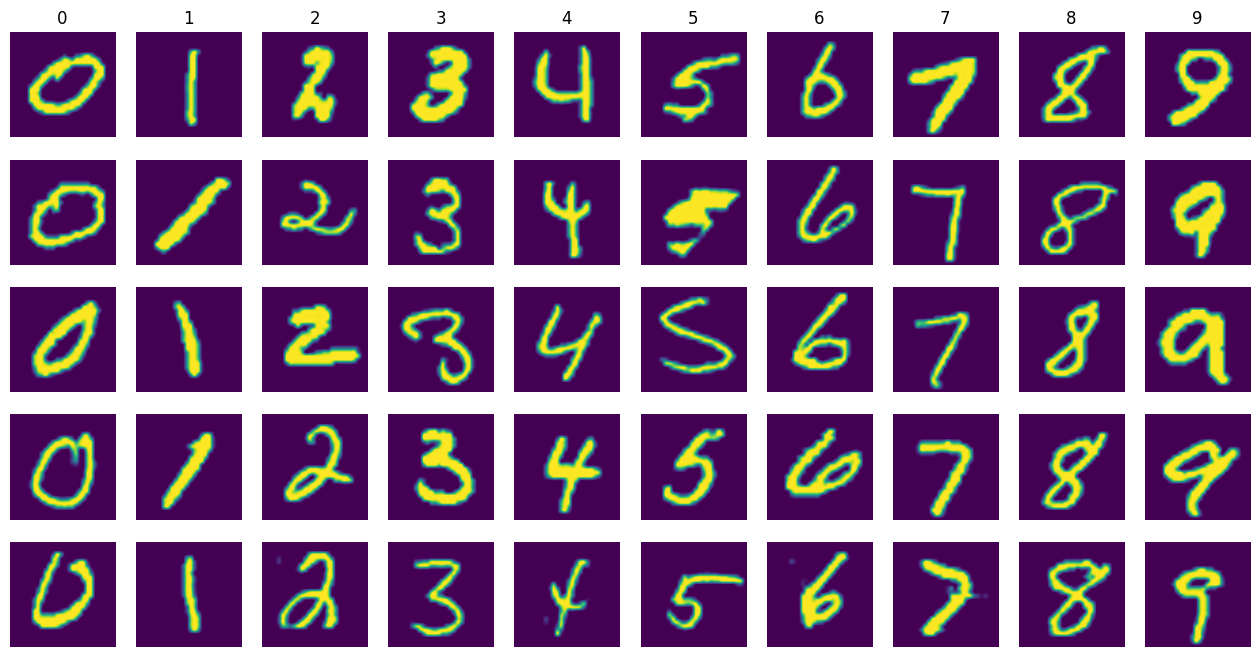

In [3]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
samples_per_class = 5

plt.figure(figsize=(16, 8))

for cls, name in enumerate(class_names):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(samples_per_class, num_classes, i * num_classes + cls + 1)
        plt.imshow(X_train[idx], interpolation='spline16')
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])



# **Data Preprocessing**


In [4]:
# Convert 3D arrays to 2D arrays
X_train = X_train.reshape([-1, num_features])
X_test  =  X_test.reshape([-1, num_features])

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (60000, 784)
Test  data shape: (10000, 784)


In [5]:
# convert pixel range from [0, 255] to [0., 1.]
X_train = X_train.astype('float32')
x_test  = X_test.astype('float32')

mu = np.mean(X_train, axis=0)

X_train -= mu
X_train /= 255.0

x_test -= mu
x_test /= 255.0

**One-hot encodding**


*   In one-hot encoding, we represent labels using vectors.




In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


# Model: CNN

**Converting dataset to 4D array**

In [7]:
X_train = X_train.reshape((-1, image_size, image_size ,num_channel))
X_test  =  X_test.reshape((-1, image_size, image_size , num_channel))
x_test  =  x_test.reshape((-1, image_size, image_size , num_channel))

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
def create_cnn():
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(X_train.shape[1:]), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Classifier
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = create_cnn()

#print model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        36928     
                                                        

In [11]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train[:num_train], y_train[:num_train],
          batch_size=200,
          epochs=5,
          validation_data=(X_train[num_train:], y_train[num_train:]))

Epoch 1/5
295/295 [==============================] - 311s 1s/step - loss: 0.3368 - accuracy: 0.8964 - val_loss: 0.0703 - val_accuracy: 0.9820
Epoch 2/5
295/295 [==============================] - 305s 1s/step - loss: 0.0989 - accuracy: 0.9727 - val_loss: 0.0547 - val_accuracy: 0.9880
Epoch 3/5
295/295 [==============================] - 303s 1s/step - loss: 0.0693 - accuracy: 0.9808 - val_loss: 0.0370 - val_accuracy: 0.9940
Epoch 4/5
295/295 [==============================] - 305s 1s/step - loss: 0.0545 - accuracy: 0.9844 - val_loss: 0.0348 - val_accuracy: 0.9950
Epoch 5/5
295/295 [==============================] - 301s 1s/step - loss: 0.0444 - accuracy: 0.9880 - val_loss: 0.0427 - val_accuracy: 0.9910


In [12]:
model.evaluate(x_test, y_test, batch_size=200)

50/50 [==============================] - 8s 168ms/step - loss: 0.0216 - accuracy: 0.9935


[0.02163476124405861, 0.9934999942779541]